In [10]:
from nilmtk.dataset_converters import convert_refit

# Convert the REFIT dataset to the NILMTK format
convert_refit( '/home/athanpan/Λήψεις/CLEAN_REFIT_081116/','/home/athanpan/Λήψεις/CLEAN_REFIT_081116/newrefit.h5')

Loading house 1... Using CLEAN filenames (CLEAN_HouseXX.csv)
1 2 3 4 5 6 7 8 9 10 
Loading house 2... 1 2 3 4 5 6 7 8 9 10 
Loading house 3... 1 2 3 4 5 6 7 8 9 10 
Loading house 4... 1 2 3 4 5 6 7 8 9 10 
Loading house 5... 1 2 3 4 5 6 7 8 9 10 
Loading house 6... 1 2 3 4 5 6 7 8 9 10 
Loading house 7... 1 2 3 4 5 6 7 8 9 10 
Loading house 8... 1 2 3 4 5 6 7 8 9 10 
Loading house 9... 1 2 3 4 5 6 7 8 9 10 
Loading house 10... 1 2 3 4 5 6 7 8 9 10 
Loading house 11... 1 2 3 4 5 6 7 8 9 10 
Loading house 12... 1 2 3 4 5 6 7 8 9 10 
Loading house 13... 1 2 3 4 5 6 7 8 9 10 
Loading house 15... 1 2 3 4 5 6 7 8 9 10 
Loading house 16... 1 2 3 4 5 6 7 8 9 10 
Loading house 17... 1 2 3 4 5 6 7 8 9 10 
Loading house 18... 1 2 3 4 5 6 7 8 9 10 
Loading house 19... 1 2 3 4 5 6 7 8 9 10 
Loading house 20... 1 2 3 4 5 6 7 8 9 10 
Loading house 21... 1 2 3 4 5 6 7 8 9 10 
Loaded metadata
Done converting YAML metadata to HDF5!
Done converting REFIT to HDF5!


In [51]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [240]:
import warnings; warnings.filterwarnings('ignore')

from nilmtk import DataSet
#train = DataSet('C:\\Users\\User\\Desktop\\ukdale\\ukdale.h5')
train = DataSet(r'/home/athanpan/Λήψεις/CLEAN_REFIT_081116/newrefit.h5')
train.set_window("02-1-2014","03-31-2014")
#train.set_window(end="2014-03-30") #Use data only until 4/30/2011   train.set_window("10-7-2014","10-14-2014")
train_elec = train.buildings[10].elec

In [241]:
#train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
train_mains = train_elec.mains()
#next(train_mains.load(sample_period=1))
#print(next(train_mains.load(sample_period=1)))
#train_mains = train_elec.submeters()

#print(train_elec)
print(train_elec.mains().power_series_all_data().head())

print(train_elec.submeters())
train_meter = train_elec.submeters()['dish washer'] # The microwave meter that is used as a training target
print(train_meter)

Unix
2014-02-01 00:03:17+00:00    193
2014-02-01 00:03:31+00:00    193
2014-02-01 00:03:45+00:00    193
2014-02-01 00:03:58+00:00    193
2014-02-01 00:04:12+00:00    191
Name: (power, active), dtype: int64
MeterGroup(meters=
  ElecMeter(instance=2, building=10, dataset='REFIT', appliances=[Appliance(type='food processor', instance=1)])
  ElecMeter(instance=3, building=10, dataset='REFIT', appliances=[Appliance(type='toaster', instance=1)])
  ElecMeter(instance=4, building=10, dataset='REFIT', appliances=[Appliance(type='freezer', instance=1)])
  ElecMeter(instance=5, building=10, dataset='REFIT', appliances=[Appliance(type='fridge freezer', instance=1)])
  ElecMeter(instance=6, building=10, dataset='REFIT', appliances=[Appliance(type='washing machine', instance=1)])
  ElecMeter(instance=7, building=10, dataset='REFIT', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=8, building=10, dataset='REFIT', appliances=[Appliance(type='television', instance=1)])
  El

In [242]:
def _normalize(chunk, mmax):
    '''Normalizes timeseries

    Parameters
    ----------
    chunk : the timeseries to normalize
    max : max value of the powerseries

    Returns: Normalized timeseries
    '''
    tchunk = chunk / mmax
    return tchunk

In [243]:
import numpy as np
def apply_on_chunk(mainchunk, meterchunk, epochs=5, batch_size=8, window_size=1):
    '''Train using only one chunk

    Parameters
    ----------
    mainchunk : chunk of site meter
    meterchunk : chunk of appliance
    epochs : number of epochs for training
    batch_size : size of batch used for training
    '''
    
    print("mainchunk  : ",np.shape(mainchunk))
    
    # Replace NaNs with 0s
    mainchunk.fillna(0, inplace=True)
    meterchunk.fillna(0, inplace=True)
    #ix = mainchunk.index.intersection(meterchunk.index)
    #mainchunk = np.array(mainchunk[ix])
    #meterchunk = np.array(meterchunk[ix])

    
    print("mainchunk  : ",np.shape(mainchunk))
    
    
    indexer = np.arange(window_size)[None, :] + np.arange(len(mainchunk)-window_size+1)[:, None]
    mainchunk = mainchunk[indexer]
    meterchunk = meterchunk[window_size-1:]
    mainchunk = np.reshape(mainchunk, (mainchunk.shape[0], mainchunk.shape[1],1))
    print("ιndex  : ", indexer)
    #self.model.fit(mainchunk, meterchunk, epochs=epochs, batch_size=batch_size, shuffle=True)
    return mainchunk, meterchunk




def convert_time(timestamp):
    return pd.to_datetime(timestamp, unit='ms')

def get_second(date):
    return date.second

def get_minute(date):
    return date.minute

def get_hour(date):
    return date.hour

def get_day(date):
    return date.day

def get_month(date):
    return date.month

def get_year(date):
    return date.year

In [244]:
main_power_series  = train_mains.power_series()
meter_power_series = train_meter.power_series()
mmax = 1


    
# Train chunks
run = True
mainchunk = next(main_power_series)
meterchunk = next(meter_power_series)
if mmax == None:
    mmax = mainchunk.max()

while(run):
    
    mainchunk = _normalize(mainchunk, mmax)
    meterchunk = _normalize(meterchunk, mmax)

    #self.train_on_chunk(mainchunk, meterchunk, epochs, batch_size)
    try:
        mainchunk = next(main_power_series)
        meterchunk = next(meter_power_series)
        print("1")
        mainchunks, meterchunks = apply_on_chunk(mainchunk, meterchunk, epochs, batch_size)
    except Exception as e:
        print(e)
        run = False

In [245]:
import numpy as np
mainchunks, meterchunks = apply_on_chunk(mainchunk, meterchunk)

print("mainchunks  : ",np.shape(mainchunks))

print("meterchunks : ",np.shape(meterchunks))

mainchunk  :  (478747,)
mainchunk  :  (478747,)
mainchunks  :  (478747, 1, 1)
meterchunks :  (478747,)


In [246]:
df_main  = mainchunk.to_frame()  
df_meter = meterchunk.to_frame()

df_main['power appliance'] = df_meter

df_main.columns =['power apparent','power appliance']

df_meter = df_main['power appliance']



df_main["power appliance"].fillna("0", inplace = True)
df_main = df_main.reset_index()

df_main.columns =['date','power apparent','power appliance']


df_main['second']   = df_main['date'].apply(get_second)
df_main['minute']   = df_main['date'].apply(get_minute)
df_main['hour']   = df_main['date'].apply(get_hour)
df_main['day']    = df_main['date'].apply(get_day)
df_main['month']  = df_main['date'].apply(get_month)
df_main['year']   = df_main['date'].apply(get_year)

In [247]:
print(df_main)


                            date  power apparent  power appliance  second  \
0      2014-02-01 00:03:17+00:00           193.0              0.0      17   
1      2014-02-01 00:03:31+00:00           193.0              0.0      31   
2      2014-02-01 00:03:45+00:00           193.0              0.0      45   
3      2014-02-01 00:03:58+00:00           193.0              0.0      58   
4      2014-02-01 00:04:12+00:00           191.0              0.0      12   
...                          ...             ...              ...     ...   
478742 2014-03-30 23:59:30+01:00          2169.0           1717.0      30   
478743 2014-03-30 23:59:36+01:00          2169.0           1717.0      36   
478744 2014-03-30 23:59:43+01:00          2169.0           1717.0      43   
478745 2014-03-30 23:59:49+01:00          2169.0           1717.0      49   
478746 2014-03-30 23:59:56+01:00          2169.0           1717.0      56   

        minute  hour  day  month  year  
0            3     0    1      2  

In [248]:
df = df_main['date'].to_frame()
df['year'] = df_main['year']
df['month'] = df_main['month']
df['day'] = df_main['day']
df['hour'] = df_main['hour']
df['minute'] = df_main['minute']
df['second'] = df_main['second']
df['power apparent'] = df_main['power apparent']
df['power appliance'] = df_main['power appliance']

In [249]:
df.head(10)

,date,year,month,day,hour,minute,second,power apparent,power appliance
0,2014-02-01 00:03:17+00:00,2014,2,1,0,3,17,193.0,0.0
1,2014-02-01 00:03:31+00:00,2014,2,1,0,3,31,193.0,0.0
2,2014-02-01 00:03:45+00:00,2014,2,1,0,3,45,193.0,0.0
3,2014-02-01 00:03:58+00:00,2014,2,1,0,3,58,193.0,0.0
4,2014-02-01 00:04:12+00:00,2014,2,1,0,4,12,191.0,0.0
5,2014-02-01 00:04:26+00:00,2014,2,1,0,4,26,194.0,0.0
6,2014-02-01 00:04:39+00:00,2014,2,1,0,4,39,194.0,0.0
7,2014-02-01 00:04:53+00:00,2014,2,1,0,4,53,195.0,0.0
8,2014-02-01 00:05:07+00:00,2014,2,1,0,5,7,195.0,0.0
9,2014-02-01 00:05:21+00:00,2014,2,1,0,5,21,255.0,0.0


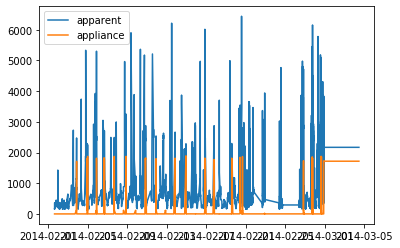

In [250]:
import matplotlib.pyplot as plt
appliance = df['power appliance'][200:100000].astype(int)
apparent = df['power apparent'][200:100000].astype(int)
time = df['date'][200:100000]

fig, ax = plt.subplots()
ax.plot(time, apparent, label="apparent")
ax.plot(time, appliance, label="appliance")
ax.legend()

plt.show()

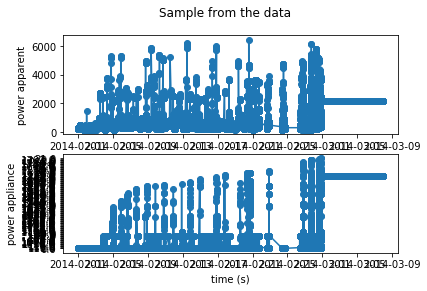

In [251]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Sample from the data')

ax1.plot(df['date'][:150000], df['power apparent'][:150000], 'o-')
ax1.set_ylabel('power apparent')

ax2.plot(df['date'][:150000], df['power appliance'][:150000].astype(str), 'o-')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('power appliance')

plt.show()

In [252]:
def min_to_sec_data(value1, value2):
    
    diff = (value2-value1)/60
    val = value1
    points = [value1]
    
    for i in range(60):
        val += diff#(diff/60)*i
        points.append(val)
    return points

In [253]:
mainchunk.values
uppsampled_mainchunks = []

for i in range(0,len(mainchunk.values)-1,2):
    uppsampled_mainchunks.append(min_to_sec_data(mainchunk.values[i],mainchunk.values[i+1]))

In [254]:
uppsampled_mainchunks = np.array(uppsampled_mainchunks)

In [255]:
uppsampled_mainchunks = np.reshape(uppsampled_mainchunks, (uppsampled_mainchunks.shape[0]*uppsampled_mainchunks.shape[1],1))
uppsampled_mainchunks

array([[ 193.],
       [ 193.],
       [ 193.],
       ...,
       [2169.],
       [2169.],
       [2169.]])

In [256]:
print(uppsampled_mainchunks.shape)

(14601753, 1)


In [257]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def local_mean_range(P):
    d = np.array(P)

    consec = 3
    offset = 0
    nsub = 1
    pace = 1

    s = d.strides[0]
    ngroups= (d.shape[0] - (consec + (nsub-1)*offset - 1))//pace
    a = as_strided(d, shape=(ngroups, nsub, consec),
                   strides=(pace*s, offset*s, 1*s))

    local_mean = a.mean(axis=-1).mean(axis=-1)
    return local_mean[0]

def deviation_range(P):
    return np.std(P)

mean = local_mean_range(P=[10,5,5])
dev  = deviation_range(P=[10,5,5])

def event_detected(P):
    detected = True
    
    return detected

print("Computing for [10,5,5]\n")
print('local mean\t   deviation\t\tvariance\t\taverage')
print(mean, dev, np.var([10,5,5]), np.average([10,5,5]))

Computing for [10,5,5]

local mean	   deviation		variance		average
6.666666666666667 2.357022603955158 5.5555555555555545 6.666666666666667


In [258]:
def three_point_method(P, P_s=[]):
    """
    three point method which will be applied on the dataset alongside the reconstruct_P
    """
    P_bar  =  np.average(P)
    teta_p =  deviation_range(P)
    teta_g = deviation_range(P)
    
    try:
        ps_previous = P_s[-1]
    except:
        ps_previous = 0
    
    if teta_p > teta_g:
        P_s.append(ps_previous)
    else:
        P_s.append(P_bar)
        
    return P_s

def reconstruct_P(P, P_s=[0,0], T_q=[0,0],t='',P_events=[], N_events=[]):
    """
    P is our three points which are needed to calculate the deviation
    P_s is the cleaned new signal
    T_q is the new array that will contain the q events
    t is the time at which the event started
    """
    Event_Detected = False
    
    teta_g = deviation_range(P)
    try:
        delta_Ps = P_s[-1] - P_s[-2]
    except:
        if P_s[-1]:
            delta_Ps = P_s[-1]
        else:
            delta_Ps =0
    
    if delta_Ps>=teta_g:
        T_q.append(t)
        Event_Detected = True
        
        
    P_events.append(0)
    N_events.append(0)
    
    if delta_Ps>0:
        P_events[-1] = P_s[-1]
    elif delta_Ps<0:
        N_events[-1] = P_s[-1]
        
    return T_q, P_events, N_events

In [259]:
from tqdm import tqdm
T_q = [df['date'][0]]
P_events, N_events = [],[]
P_s = []

for i in tqdm(range(0, len(df['power appliance']))):
    
    P = df['power appliance'][i:i+3].astype(float).values
    
    # Applying the three points method
    P_s = three_point_method(P, P_s)
    
    # Getting the event data
    T_q, P_events, N_events = reconstruct_P(P, P_s, T_q=T_q,t=df['date'][i],P_events=P_events, N_events=N_events)
    

100%|██████████| 478747/478747 [07:28<00:00, 1066.88it/s]


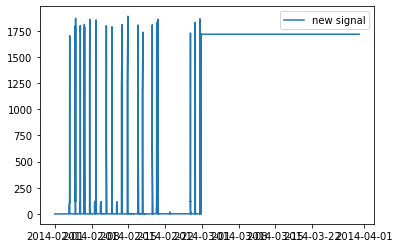

In [260]:
appliance = P_s
time = df['date'][:50]

fig, ax = plt.subplots()
ax.plot(df['date'], P_s, label="new signal")
ax.legend()

plt.show()

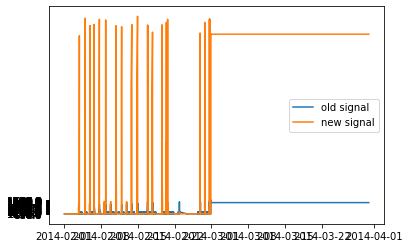

In [261]:
appliance = P_s
time = df['date'][:50]

fig, ax = plt.subplots()

ax.plot(df['date'], df['power appliance'].astype(str), label="old signal")

ax.plot(df['date'], P_s, label="new signal")

ax.legend()

plt.show()

[   0.    0.    0. ... 1717. 1717. 1717.]


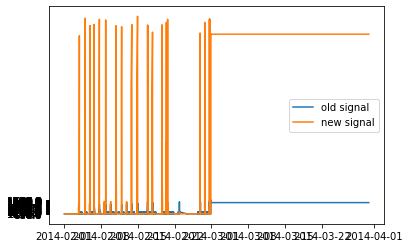

In [262]:
appliance = P_s
time = df['date'][:50]

P_string = np.array(P_s)#.dtype(np.int32)      # 32-bit integer
print(P_string)
fig, ax = plt.subplots()

ax.plot(df['date'], df['power appliance'].astype(str), label="old signal")
#ax.plot(df['date'][0:15], P_string[0:15], label="new signal")
ax.plot(df['date'], P_s, label="new signal")


ax.legend()

plt.show()

In [263]:
print(np.shape(P_s))
print(np.shape(T_q))

(478747,)
(454202,)


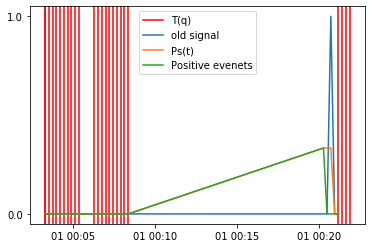

In [269]:
appliance = P_s
time = df['date'][:50]

#df_temp = pd.DataFrame(np.array(T_q[:50]), columns=list('abc'))
# pd.to_datetime(T_q[:50].datetime)

fig, ax = plt.subplots()

plt.axvline(T_q[0], color='red', label="T(q)")

for i in range(1,25):
    plt.axvline(T_q[i], color='red')
    
ax.plot(df['date'][:25], df['power appliance'][:25].astype(str), label="old signal")

ax.plot(df['date'][:25], P_s[:25], label="Ps(t)")
ax.plot(df['date'][:25], P_events[:25], label="Positive evenets")





    
ax.legend()

plt.show()

In [270]:
df['new signal'] = np.array(P_s)#.to_frame()  P_events  positive events

In [271]:
df.head(10)

,date,year,month,day,hour,minute,second,power apparent,power appliance,new signal
0,2014-02-01 00:03:17+00:00,2014,2,1,0,3,17,193.0,0.0,0.0
1,2014-02-01 00:03:31+00:00,2014,2,1,0,3,31,193.0,0.0,0.0
2,2014-02-01 00:03:45+00:00,2014,2,1,0,3,45,193.0,0.0,0.0
3,2014-02-01 00:03:58+00:00,2014,2,1,0,3,58,193.0,0.0,0.0
4,2014-02-01 00:04:12+00:00,2014,2,1,0,4,12,191.0,0.0,0.0
5,2014-02-01 00:04:26+00:00,2014,2,1,0,4,26,194.0,0.0,0.0
6,2014-02-01 00:04:39+00:00,2014,2,1,0,4,39,194.0,0.0,0.0
7,2014-02-01 00:04:53+00:00,2014,2,1,0,4,53,195.0,0.0,0.0
8,2014-02-01 00:05:07+00:00,2014,2,1,0,5,7,195.0,0.0,0.0
9,2014-02-01 00:05:21+00:00,2014,2,1,0,5,21,255.0,0.0,0.0


In [272]:
df_clust = df['new signal'].to_frame()
df_clust['power apparent'] = df['power apparent'] 

X = df_clust.values
X

array([[   0.,  193.],
       [   0.,  193.],
       [   0.,  193.],
       ...,
       [1717., 2169.],
       [1717., 2169.],
       [1717., 2169.]])

In [273]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

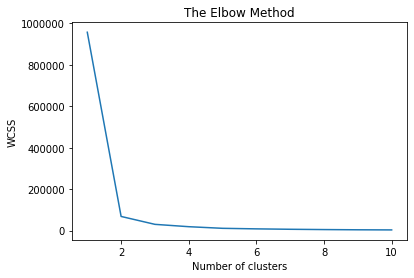

In [274]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [275]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
#y_kmeans = kmeans.fit_predict(X)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

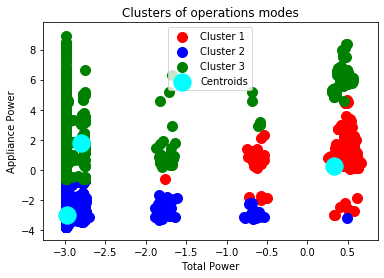

In [276]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'cyan', label = 'Centroids')
plt.title('Clusters of operations modes')
plt.xlabel('Total Power')
plt.ylabel('Appliance Power')
plt.legend()
plt.show()

In [279]:
import warnings; warnings.filterwarnings('ignore')

from nilmtk import DataSet
#train = DataSet('C:\\Users\\User\\Desktop\\ukdale\\ukdale.h5')
test = DataSet(r'/home/athanpan/Λήψεις/CLEAN_REFIT_081116/newrefit.h5')
test.set_window("03-1-2014","04-30-2014")
#train.set_window(end="2014-03-30") #Use data only until 4/30/2011   train.set_window("10-7-2014","10-14-2014")
test_elec = train.buildings[10].elec

In [280]:
#train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
test_mains = test_elec.mains()
#next(train_mains.load(sample_period=1))
#print(next(train_mains.load(sample_period=1)))
#train_mains = train_elec.submeters()

#print(train_elec)
print(test_elec.mains().power_series_all_data().head())

print(test_elec.submeters())
test_meter = test_elec.submeters()['dish washer'] # The microwave meter that is used as a training target
print(test_meter)

Unix
2014-03-01 00:00:01+00:00    2169
2014-03-01 00:00:30+00:00    2169
2014-03-01 00:00:43+00:00    2169
2014-03-01 00:00:56+00:00    2169
2014-03-01 00:01:09+00:00    2169
Name: (power, active), dtype: int64
MeterGroup(meters=
  ElecMeter(instance=2, building=10, dataset='REFIT', appliances=[Appliance(type='food processor', instance=1)])
  ElecMeter(instance=3, building=10, dataset='REFIT', appliances=[Appliance(type='toaster', instance=1)])
  ElecMeter(instance=4, building=10, dataset='REFIT', appliances=[Appliance(type='freezer', instance=1)])
  ElecMeter(instance=5, building=10, dataset='REFIT', appliances=[Appliance(type='fridge freezer', instance=1)])
  ElecMeter(instance=6, building=10, dataset='REFIT', appliances=[Appliance(type='washing machine', instance=1)])
  ElecMeter(instance=7, building=10, dataset='REFIT', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=8, building=10, dataset='REFIT', appliances=[Appliance(type='television', instance=1)])

In [281]:
main_power_series2  = test_mains.power_series()
meter_power_series2 = test_meter.power_series()
mmax = 1


    
# Train chunks
run = True
mainchunk2 = next(main_power_series2)
meterchunk2 = next(meter_power_series2)
if mmax == None:
    mmax = mainchunk2.max()

while(run):
    
    mainchunk2 = _normalize(mainchunk2, mmax)
    meterchunk2 = _normalize(meterchunk2, mmax)

    #self.train_on_chunk(mainchunk, meterchunk, epochs, batch_size)
    try:
        mainchunk2 = next(main_power_series2)
        meterchunk2 = next(meter_power_series2)
        print("1")
        mainchunks2, meterchunks2 = apply_on_chunk(mainchunk2, meterchunk2, epochs, batch_size)
    except Exception as e:
        print(e)
        run = False

In [282]:
import numpy as np
mainchunks2, meterchunks2 = apply_on_chunk(mainchunk2, meterchunk2)

print("mainchunks2  : ",np.shape(mainchunks2))

print("meterchunks2 : ",np.shape(meterchunks2))

mainchunk  :  (853287,)
mainchunk  :  (853287,)
mainchunks2  :  (853287, 1, 1)
meterchunks2 :  (853287,)


In [283]:
df_main2  = mainchunk2.to_frame()  
df_meter2 = meterchunk2.to_frame()

df_main2['power appliance'] = df_meter2

df_main2.columns =['power apparent','power appliance']

df_meter2 = df_main2['power appliance']



df_main2["power appliance"].fillna("0", inplace = True)
df_main2 = df_main2.reset_index()

df_main2.columns =['date','power apparent','power appliance']


df_main2['second']   = df_main2['date'].apply(get_second)
df_main2['minute']   = df_main2['date'].apply(get_minute)
df_main2['hour']   = df_main2['date'].apply(get_hour)
df_main2['day']    = df_main2['date'].apply(get_day)
df_main2['month']  = df_main2['date'].apply(get_month)
df_main2['year']   = df_main2['date'].apply(get_year)

In [284]:
print(df_main2)

                            date  power apparent  power appliance  second  \
0      2014-03-01 00:00:01+00:00          2169.0           1717.0       1   
1      2014-03-01 00:00:30+00:00          2169.0           1717.0      30   
2      2014-03-01 00:00:43+00:00          2169.0           1717.0      43   
3      2014-03-01 00:00:56+00:00          2169.0           1717.0      56   
4      2014-03-01 00:01:09+00:00          2169.0           1717.0       9   
...                          ...             ...              ...     ...   
853282 2014-04-29 23:59:29+01:00           330.0              1.0      29   
853283 2014-04-29 23:59:33+01:00           331.0              2.0      33   
853284 2014-04-29 23:59:43+01:00           327.0              1.0      43   
853285 2014-04-29 23:59:47+01:00           327.0              2.0      47   
853286 2014-04-29 23:59:57+01:00           331.0              2.0      57   

        minute  hour  day  month  year  
0            0     0    1      3  

In [285]:
df2 = df_main2['date'].to_frame()
df2['year'] = df_main2['year']
df2['month'] = df_main2['month']
df2['day'] = df_main2['day']
df2['hour'] = df_main2['hour']
df2['minute'] = df_main2['minute']
df2['second'] = df_main2['second']
df2['power apparent'] = df_main2['power apparent']
df2['power appliance'] = df_main2['power appliance']

In [286]:
df2.head(10)

,date,year,month,day,hour,minute,second,power apparent,power appliance
0,2014-03-01 00:00:01+00:00,2014,3,1,0,0,1,2169.0,1717.0
1,2014-03-01 00:00:30+00:00,2014,3,1,0,0,30,2169.0,1717.0
2,2014-03-01 00:00:43+00:00,2014,3,1,0,0,43,2169.0,1717.0
3,2014-03-01 00:00:56+00:00,2014,3,1,0,0,56,2169.0,1717.0
4,2014-03-01 00:01:09+00:00,2014,3,1,0,1,9,2169.0,1717.0
5,2014-03-01 00:01:17+00:00,2014,3,1,0,1,17,2169.0,1717.0
6,2014-03-01 00:01:22+00:00,2014,3,1,0,1,22,2169.0,1717.0
7,2014-03-01 00:01:30+00:00,2014,3,1,0,1,30,2169.0,1717.0
8,2014-03-01 00:01:35+00:00,2014,3,1,0,1,35,2169.0,1717.0
9,2014-03-01 00:01:43+00:00,2014,3,1,0,1,43,2169.0,1717.0


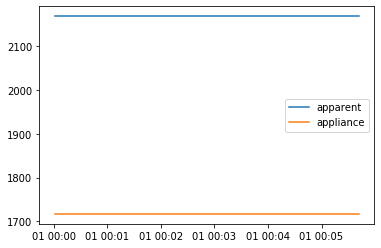

In [287]:
import matplotlib.pyplot as plt
appliance2 = df2['power appliance'][:50].astype(int)
apparent2 = df2['power apparent'][:50].astype(int)
time2 = df2['date'][:50]

fig, ax = plt.subplots()
ax.plot(time2, apparent2, label="apparent")
ax.plot(time2, appliance2, label="appliance")
ax.legend()

plt.show()

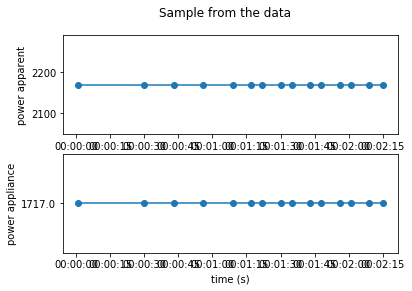

In [288]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Sample from the data')

ax1.plot(df2['date'][:15], df2['power apparent'][:15], 'o-')
ax1.set_ylabel('power apparent')

ax2.plot(df2['date'][:15], df2['power appliance'][:15].astype(str), 'o-')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('power appliance')

plt.show()

In [289]:
mainchunk2.values
uppsampled_mainchunks2 = []

for i in range(0,len(mainchunk2.values)-1,2):
    uppsampled_mainchunks2.append(min_to_sec_data(mainchunk2.values[i],mainchunk2.values[i+1]))

In [290]:
uppsampled_mainchunks2 = np.array(uppsampled_mainchunks2)

In [291]:
uppsampled_mainchunks2 = np.reshape(uppsampled_mainchunks2, (uppsampled_mainchunks2.shape[0]*uppsampled_mainchunks2.shape[1],1))
uppsampled_mainchunks2

array([[2169.],
       [2169.],
       [2169.],
       ...,
       [ 327.],
       [ 327.],
       [ 327.]])

In [292]:
print(uppsampled_mainchunks2.shape)

(26025223, 1)


In [293]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def local_mean_range2(P2):
    d2 = np.array(P2)

    consec2 = 3
    offset2 = 0
    nsub2 = 1
    pace2 = 1

    s2 = d2.strides[0]
    ngroups2= (d2.shape[0] - (consec2 + (nsub2-1)*offset2 - 1))//pace2
    a2 = as_strided(d2, shape=(ngroups2, nsub2, consec2),
                   strides=(pace2*s2, offset2*s2, 1*s2))

    local_mean2 = a2.mean(axis=-1).mean(axis=-1)
    return local_mean2[0]

def deviation_range2(P2):
    return np.std(P2)

mean2 = local_mean_range2(P2=[10,5,5])
dev2  = deviation_range2(P2=[10,5,5])

def event_detected2(P2):
    detected2 = True
    
    return detected2

print("Computing for [10,5,5]\n")
print('local mean\t   deviation\t\tvariance\t\taverage')
print(mean2, dev2, np.var([10,5,5]), np.average([10,5,5]))

Computing for [10,5,5]

local mean	   deviation		variance		average
6.666666666666667 2.357022603955158 5.5555555555555545 6.666666666666667


In [294]:
def three_point_method2(P2, P_s2=[]):
    """
    three point method which will be applied on the dataset alongside the reconstruct_P
    """
    P_bar2  =  np.average(P2)
    teta_p2 =  deviation_range(P2)
    teta_g2 = deviation_range(P2)
    
    try:
        ps_previous2 = P_s2[-1]
    except:
        ps_previous2 = 0
    
    if teta_p2 > teta_g2:
        P_s2.append(ps_previous2)
    else:
        P_s2.append(P_bar2)
        
    return P_s2


def reconstruct_P2(P2, P_s2=[0,0], T_q2=[0,0],t2='',P_events2=[], N_events2=[]):
    """
    P is our three points which are needed to calculate the deviation
    P_s is the cleaned new signal
    T_q is the new array that will contain the q events
    t is the time at which the event started
    """
    Event_Detected2 = False
    
    teta_g2 = deviation_range2(P2)
    try:
        delta_Ps2 = P_s2[-1] - P_s2[-2]
    except:
        if P_s2[-1]:
            delta_Ps2 = P_s2[-1]
        else:
            delta_Ps2 =0
    
    if delta_Ps2>=teta_g2:
        T_q2.append(t2)
        Event_Detected2 = True
        
        
    P_events2.append(0)
    N_events2.append(0)
    
    if delta_Ps2>0:
        P_events2[-1] = P_s2[-1]
    elif delta_Ps2<0:
        N_events2[-1] = P_s2[-1]
        
    return T_q2, P_events2, N_events2

In [295]:
from tqdm import tqdm
T_q2 = [df['date'][0]]
P_events2, N_events2 = [],[]
P_s2 = []

for i in tqdm(range(0, len(df2['power appliance']))):
    
    P2 = df2['power appliance'][i:i+3].astype(float).values
    
    # Applying the three points method
    P_s2 = three_point_method2(P2, P_s2)
    
    # Getting the event data
    T_q2, P_events2, N_events2 = reconstruct_P2(P2, P_s2, T_q2 = T_q2,t2 = df2['date'][i],P_events2 = P_events2, N_events2 = N_events2)
    

100%|██████████| 853287/853287 [13:46<00:00, 1032.67it/s]


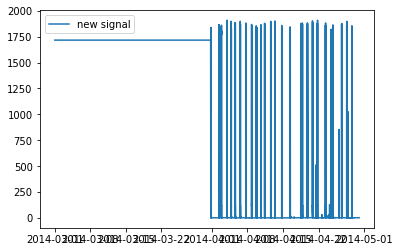

In [296]:
appliance2 = P_s2
time2 = df2['date'][:50]

fig, ax = plt.subplots()
ax.plot(df2['date'], P_s2, label="new signal")
ax.legend()

plt.show()

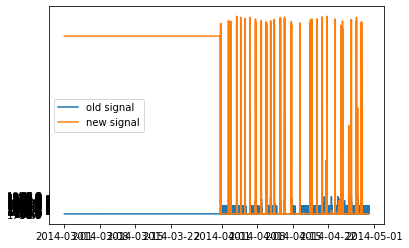

In [297]:
appliance2 = P_s2
time2 = df2['date'][:50]

fig, ax = plt.subplots()

ax.plot(df2['date'], df2['power appliance'].astype(str), label="old signal")

ax.plot(df2['date'], P_s2, label="new signal")

ax.legend()

plt.show()

[1.71700000e+03 1.71700000e+03 1.71700000e+03 ... 1.66666667e+00
 2.00000000e+00 2.00000000e+00]


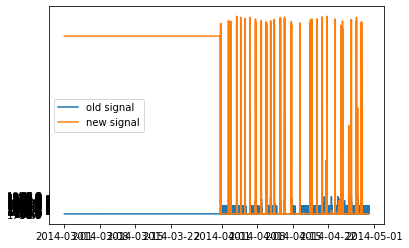

In [298]:
appliance2 = P_s2
time2 = df2['date'][:50]

P_string2 = np.array(P_s2)#.dtype(np.int32)      # 32-bit integer
print(P_string2)
fig, ax = plt.subplots()

ax.plot(df2['date'], df2['power appliance'].astype(str), label="old signal")
#ax.plot(df['date'][0:15], P_string[0:15], label="new signal")
ax.plot(df2['date'], P_s2, label="new signal")


ax.legend()

plt.show()

In [299]:
print(np.shape(P_s2))
print(np.shape(T_q2))

(853287,)
(649437,)


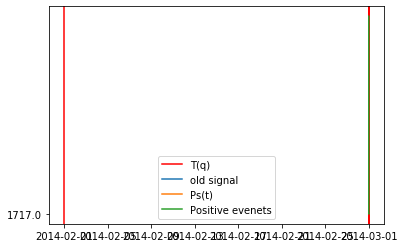

In [300]:
appliance2 = P_s2
time2 = df2['date'][:50]

#df_temp = pd.DataFrame(np.array(T_q[:50]), columns=list('abc'))
# pd.to_datetime(T_q[:50].datetime)

fig, ax = plt.subplots()

plt.axvline(T_q2[0], color='red', label="T(q)")

for i in range(1,25):
    plt.axvline(T_q2[i], color='red')
    
ax.plot(df2['date'][:25], df2['power appliance'][:25].astype(str), label="old signal")

ax.plot(df2['date'][:25], P_s2[:25], label="Ps(t)")
ax.plot(df2['date'][:25], P_events2[:25], label="Positive evenets")





    
ax.legend()

plt.show()

In [301]:
df2['new signal'] = np.array(P_s2)#.to_frame()  P_events  positive events

In [302]:
df2.head(10)

,date,year,month,day,hour,minute,second,power apparent,power appliance,new signal
0,2014-03-01 00:00:01+00:00,2014,3,1,0,0,1,2169.0,1717.0,1717.0
1,2014-03-01 00:00:30+00:00,2014,3,1,0,0,30,2169.0,1717.0,1717.0
2,2014-03-01 00:00:43+00:00,2014,3,1,0,0,43,2169.0,1717.0,1717.0
3,2014-03-01 00:00:56+00:00,2014,3,1,0,0,56,2169.0,1717.0,1717.0
4,2014-03-01 00:01:09+00:00,2014,3,1,0,1,9,2169.0,1717.0,1717.0
5,2014-03-01 00:01:17+00:00,2014,3,1,0,1,17,2169.0,1717.0,1717.0
6,2014-03-01 00:01:22+00:00,2014,3,1,0,1,22,2169.0,1717.0,1717.0
7,2014-03-01 00:01:30+00:00,2014,3,1,0,1,30,2169.0,1717.0,1717.0
8,2014-03-01 00:01:35+00:00,2014,3,1,0,1,35,2169.0,1717.0,1717.0
9,2014-03-01 00:01:43+00:00,2014,3,1,0,1,43,2169.0,1717.0,1717.0


In [303]:
df_clust2 = df2['new signal'].to_frame()
df_clust2['power apparent'] = df2['power apparent']

In [315]:
df_clust2 = df_clust2.drop(index = df_clust2.index[-374540:])

In [316]:
df_clust2

,new signal,power apparent
0,1717.000000,2169.0
1,1717.000000,2169.0
2,1717.000000,2169.0
3,1717.000000,2169.0
4,1717.000000,2169.0
...,...,...
478742,1.333333,505.0
478743,1.666667,507.0
478744,1.666667,508.0
478745,1.666667,503.0


In [317]:
Y = df_clust2.values
Y

array([[1.71700000e+03, 2.16900000e+03],
       [1.71700000e+03, 2.16900000e+03],
       [1.71700000e+03, 2.16900000e+03],
       ...,
       [1.66666667e+00, 5.08000000e+02],
       [1.66666667e+00, 5.03000000e+02],
       [1.33333333e+00, 5.02000000e+02]])

In [318]:
from sklearn.preprocessing import StandardScaler
ryh = StandardScaler()
Y = ryh.fit_transform(Y)

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

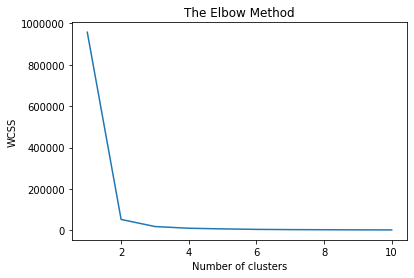

In [319]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(Y)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [320]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
ground_truth = kmeans.fit_predict(Y)

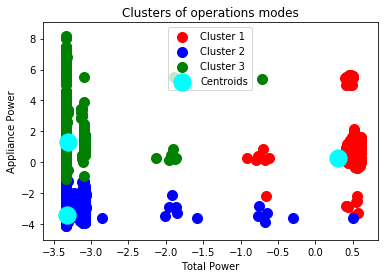

In [321]:
plt.scatter(Y[ground_truth == 0, 0], Y[ground_truth == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(Y[ground_truth == 1, 0], Y[ground_truth == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(Y[ground_truth == 2, 0], Y[ground_truth == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'cyan', label = 'Centroids')
plt.title('Clusters of operations modes')
plt.xlabel('Total Power')
plt.ylabel('Appliance Power')
plt.legend()
plt.show()

In [322]:
from sklearn import metrics
from sklearn.metrics import classification_report 

#rpaf = metrics.precision_recall_accuracy_f1(predicted,y_kmeans)
#print("============ Recall: {}".format(rpaf[0]))
#print("============ Precision: {}".format(rpaf[1]))
#print("============ Accuracy: {}".format(rpaf[2]))
#print("============ F1 Score: {}".format(rpaf[3]))


recall = metrics.recall_score(y_kmeans, ground_truth, average='weighted')
precision = metrics.precision_score(y_kmeans, ground_truth , average='weighted')
accuracy = metrics.accuracy_score(y_kmeans, ground_truth)
f1_score = metrics.f1_score(y_kmeans, ground_truth, average='weighted')

print('Precision: ',precision)
print('Recall: ',recall)
print('Accuracy: ',accuracy)
print('F1_scorey: ',f1_score)

#print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(y_kmeans, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(y_kmeans, ground_truth)))


Precision:  0.7985640500740501
Recall:  0.8152844822004106
Accuracy:  0.8152844822004106
F1_scorey:  0.8068376493188297
============ Mean absolute error(in Watts): 0.1972920979139295
